<a href="https://colab.research.google.com/github/mtzig/badwriting_OCR/blob/main/finetune_alex_augmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/mtzig/badwriting_OCR.git
%cd /content/badwriting_OCR/

Cloning into 'badwriting_OCR'...
remote: Enumerating objects: 417, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 417 (delta 102), reused 154 (delta 57), pack-reused 192
Receiving objects: 100% (417/417), 9.29 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/content/badwriting_OCR


In [ ]:
!pip install -q transformers
!pip install -q datasets jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 83.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#checkpoint_path = '/content/drive/MyDrive/MAML.pth'

In [ ]:
from utils import model_utils
from transformers import AdamW
from tqdm.notebook import tqdm
import torch
from torchvision.transforms import v2
from PIL import Image

/content/badwriting_OCR/utils/model_utils.py:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size=4
train_dataloader,eval_dataloader = model_utils.get_dataloaders(dataset_type='a', batch_size=batch_size)
# train_dataloader,eval_dataloader = model_utils.get_dataloaders(dataset_type='t', batch_size=batch_size)
# train_dataloader,eval_dataloader = model_utils.get_dataloaders(dataset_type='t', batch_size=batch_size, extended_thomas=True)
# train_dataloader,eval_dataloader = model_utils.get_dataloaders(dataset_type='t', batch_size=batch_size, extended_thomas=True, thomas_spliting_tricks=True)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])
torch.Size([4, 3, 384, 384])


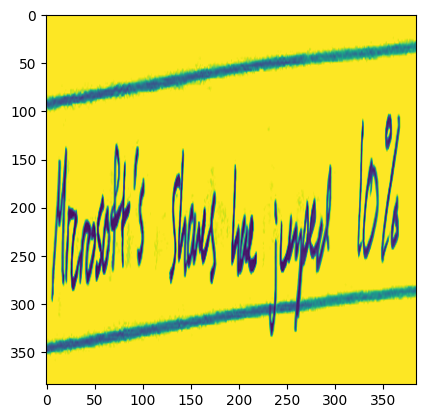

In [ ]:
import matplotlib.pyplot as plt
for batch in train_dataloader:
  tensor = batch['pixel_values']
  for i in range(batch_size):
    plt.imshow(tensor[i][0])
  print(tensor.shape)

In [ ]:
from transformers import TrOCRProcessor
import pandas as pd

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

def compute_outputs(pred_ids, label_ids):
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)


    return pred_str, label_str

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [ ]:
model = model_utils.getModel(device)

# loading the MAML checkpoint
decoder_checkpoint_path = '/content/drive/MyDrive/766_checkpoint/MAML_decoder.pth'
# decoder_checkpoint_path = '/content/drive/MyDrive/766_checkpoint/MAML_finetuned_on_thomas120trick_0216.pth'
# decoder_checkpoint_path = '/content/drive/MyDrive/766_checkpoint/MAML_finetuned_on_alex_0234.pth'

maml_checkpoint = torch.load(decoder_checkpoint_path)


model.load_state_dict(maml_checkpoint)

for pn, p in model.named_parameters():
    if 'decoder' in pn:
      p.requires_grad = True
    else:
      p.requires_grad = False

for pn, p in model.named_parameters():
  print(pn, p.requires_grad, p.shape)

In [ ]:
# start eval on thomas/alex
final_train_dataloader, final_eval_dataloader = model_utils.get_dataloaders(dataset_type='t', batch_size=batch_size, extended_thomas=True, thomas_spliting_tricks=True)
# final_train_dataloader, final_eval_dataloader = model_utils.get_dataloaders(dataset_type='a', batch_size=batch_size)



# evaluate
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(final_eval_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = model_utils.compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Validation CER:", valid_cer / len(eval_dataloader))

In [ ]:
freeze_train_cer = []

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(40):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for batch in tqdm(train_dataloader):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))

   # evaluate
   model.eval()
   valid_cer = 0.0
   with torch.no_grad():
     for batch in tqdm(eval_dataloader):
       # run batch generation
       outputs = model.generate(batch["pixel_values"].to(device))
       # compute metrics
       cer = model_utils.compute_cer(pred_ids=outputs, label_ids=batch["labels"])
       valid_cer += cer

   freeze_train_cer.append(valid_cer / len(eval_dataloader))

   print("Validation CER:", valid_cer / len(eval_dataloader))

model.save_pretrained(".")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 0: 9.022766272226969


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1339: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Validation CER: 0.8550793650793651


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 1: 6.939334789911906


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2943650793650794


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 2: 5.2970335483551025


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3900396825396826


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 3: 3.2703733245531716


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3538690476190476


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 4: 2.6988908549149833


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2662301587301587


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 5: 1.7542431900898616


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.30819444444444444


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 6: 1.357618470986684


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2775595238095238


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 7: 1.189663824935754


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2728174603174603


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 8: 0.9377741863330206


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.30634920634920637


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 9: 1.0958032334844272


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.23503968253968255


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 10: 0.7138409738739332


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.26188492063492064


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 11: 0.7451948064068953


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2823611111111111


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 12: 0.45857293779651326


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2590277777777778


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 13: 0.6031278036534786


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2675992063492063


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 14: 0.41032055268685025


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2623809523809524


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 15: 0.6988174269596735


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2851190476190476


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 16: 0.503492017587026


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3185515873015873


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 17: 0.5491514193514982


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3120238095238095


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 18: 0.4938293608526389


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.32972222222222225


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 19: 0.35888394713401794


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.29067460317460314


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 20: 0.2672772854566574


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3240873015873016


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 21: 0.5523406205077966


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.29888888888888887


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 22: 0.6827366314828396


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3280952380952381


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 23: 0.558992845316728


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3821626984126984


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 24: 0.33814630781610805


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.26809523809523805


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 25: 0.39595967282851535


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2917857142857143


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 26: 0.9240969531238079


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.27222222222222225


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 27: 1.662643941740195


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2891865079365079


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 28: 0.6444019575913748


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.42674603174603176


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 29: 0.5862488833566507


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.36160714285714285


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 30: 0.3947192306319873


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3011309523809524


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 31: 0.3124767392873764


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.29134920634920636


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 32: 0.27522051831086475


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.32339285714285715


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 33: 0.34875986352562904


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.29819444444444443


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 34: 0.2888288715233405


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.3307738095238095


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 35: 0.35875339185198146


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2968253968253968


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 36: 0.23212083677450815


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.277202380952381


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 37: 0.41793040682872135


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.2488690476190476


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 38: 0.34554565449555713


  0%|          | 0/4 [00:00<?, ?it/s]

Validation CER: 0.28652777777777777


  0%|          | 0/12 [00:00<?, ?it/s]

Loss after epoch 39: 0.31128861879309017


  0%|          | 0/4 [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


Validation CER: 0.32605158730158734


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MAML_finetuned_on_alex.pth')

In [ ]:
# final eval on thomas/alex


# evaluate
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for batch in tqdm(final_eval_dataloader):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = model_utils.compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        valid_cer += cer

print("Validation CER:", valid_cer / len(eval_dataloader))


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/MAML_finetuned_on_thomas_then_alex.pth')